In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [2]:
from tensorflow.python.client import device_lib
#tf.config.experimental.enable_mlir_graph_optimization()

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

y = get_available_gpus()
#tf.config.experimental.set_memory_growth(y[0], True)

2022-05-05 10:48:15.700120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 10:48:16.313519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 10886 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:06:00.0, compute capability: 6.1


In [3]:
subjects = [each for each in glob('./Data/'+"*")]
all_paths = [j+"/" for sub in [glob(x+'/'+"*") for x in subjects] for j in sub]

In [4]:
all_paths = all_paths[:2]

In [5]:
all_paths

['./Data/10/val/', './Data/10/train/']

In [6]:
all_train_file_paths = []
all_test_file_paths = []

for each in all_paths:
    
    if each.split("/")[-2]=='train':
        
        for _ in glob(each+'*'):
            temp_class = _.split("/")[-1]                
            all_train_file_paths+=glob(_+"/*")
            
    if each.split("/")[-2]=='val':
        
        for _ in glob(each+'*'):
            temp_class = _.split("/")[-1]                
            all_test_file_paths+=glob(_+"/*")
    

    

In [7]:
from random import shuffle

In [8]:
shuffle(all_train_file_paths)
shuffle(all_test_file_paths)

In [9]:
classes = list(set([each.split("/")[-2] for each in all_train_file_paths]))

In [10]:
n_flicks = 40

In [11]:
temp = [np.load(x).shape[-1] for x in all_train_file_paths]

global window
window = int(sum(temp)/len(temp)/40)
window = 32
stride = int(window/2)


print("Maximum and minimum signal length",max(temp),min(temp))

Maximum and minimum signal length 9360 1680


In [12]:
print(f"Max window size: {max(temp)/n_flicks} and small window size: {min(temp)/n_flicks} for 40 flicks in a file")

print(f"Average window size = {int(sum(temp)/len(temp)/40)}")


Max window size: 234.0 and small window size: 42.0 for 40 flicks in a file
Average window size = 104


In [13]:


def train_data_generator():
    file_paths = all_train_file_paths
    
    global window,stride

    classes = list(set([each.split("/")[-2] for each in file_paths]))
    for each in file_paths:

        sliced_data = []
        sliced_labels = []

        x = np.array(np.load(each).T)*10000
        #window = int(len(x)/n_flicks)
        
        # channel number starts with index !
        x = np.delete(x.T,3,0).T
        # actually the second bad channel is 31 but as we have already removed the channel the index will be 30
        x = np.delete(x.T,30,0).T
    
        start = 0
        end = start+window
        #stride = window*3

        #print(window,stride,start,end)
        label_onehot = np.zeros(20)
        label_onehot[classes.index(each.split("/")[-2])]=1
        y = np.array(label_onehot, dtype='float32')
        
        while end<len(x):

            data_slice = np.array(x[start:end])  
            
            sliced_data.append(np.array(data_slice, dtype='float32'))

            start = start + stride
            end = start + window

        shuffle(sliced_data)
        for X in sliced_data:
            yield ([X], [y])
                
                
def test_data_generator():
    file_paths = all_test_file_paths
    
    global window,stride
    
    classes = list(set([each.split("/")[-2] for each in file_paths]))
    for each in file_paths:

        sliced_data = []
        sliced_labels = []

        x = np.array(np.load(each).T)*10000
        #window = int(len(x)/n_flicks)

        # channel number starts with index !
        x = np.delete(x.T,3,0).T
        # actually the second bad channel is 31 but as we have already removed the channel the index will be 30
        x = np.delete(x.T,30,0).T

        start = 0
        end = start+window
        stride = window
        
        label_onehot = np.zeros(20)
        label_onehot[classes.index(each.split("/")[-2])]=1
        y = np.array(label_onehot, dtype='float32')
        
        while end<len(x):

            data_slice = np.array(x[start:end])

            sliced_data.append(np.array(data_slice, dtype='float32'))

            start = start + stride
            end = start + window
            
        shuffle(sliced_data)
        for X in sliced_data:
            yield ([X], [y])
                


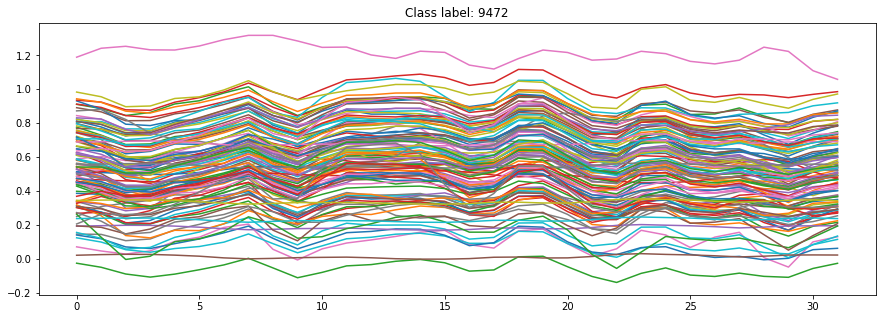

In [15]:
blah = train_data_generator()
plt.figure(figsize=(15,5))
x = next(blah)
plt.title("Class label: {}".format(classes[np.argmax(x[1][0])]))
plt.plot(x[0][0])
plt.show()

# Train data generator samples

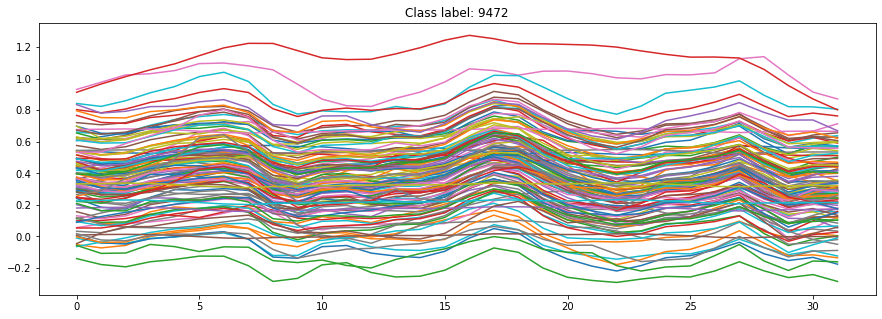

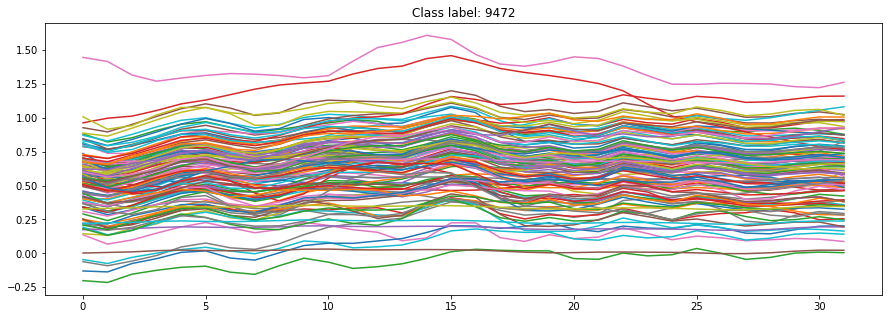

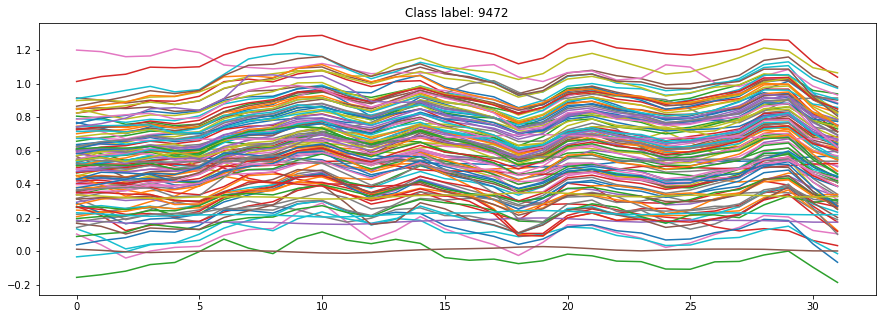

In [16]:
blah = train_data_generator()
for i in range(3):
    plt.figure(figsize=(15,5))
    x = next(blah)
    plt.title("Class label: {}".format(classes[np.argmax(x[1][0])]))
    plt.plot(x[0][0])
    plt.show()

# Test data generator samples

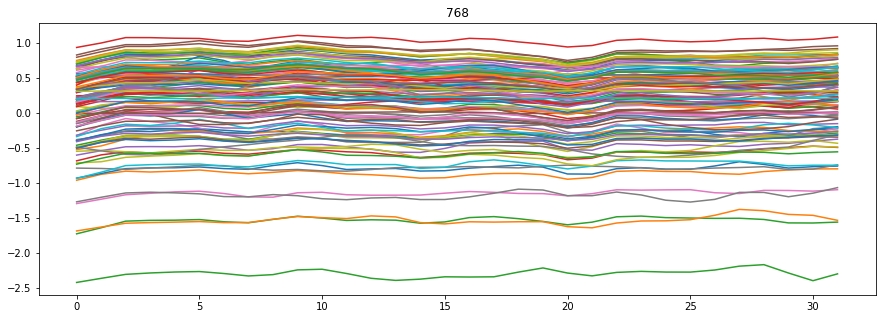

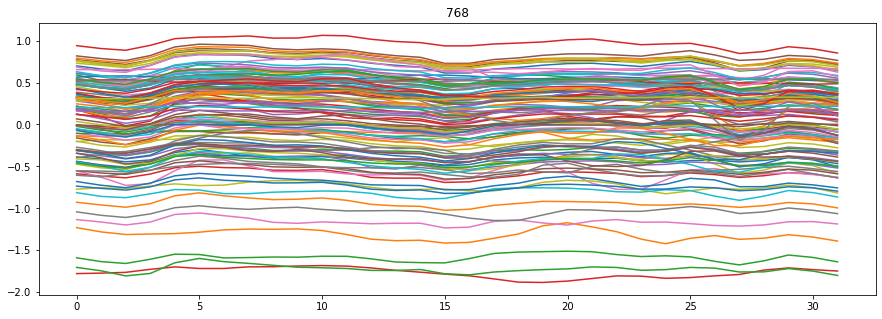

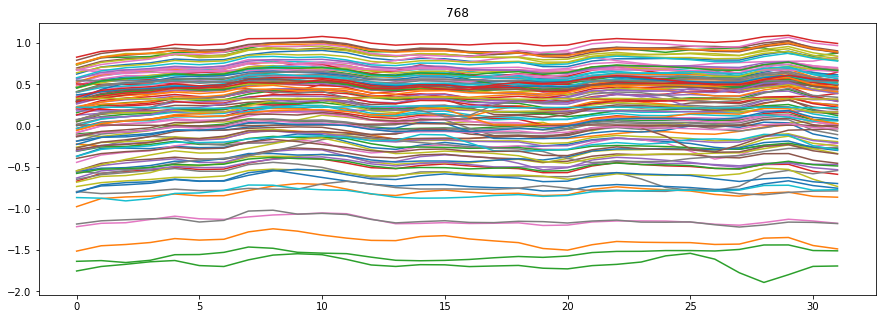

In [17]:
blah = test_data_generator()
for i in range(3):
    plt.figure(figsize=(15,5))
    x = next(blah)
    plt.title(classes[np.argmax(x[1][0])])
    plt.plot(x[0][0])
    plt.show()

In [18]:
#input_shape = (None,122,1)
input_shape = (window,120)

train_dataset = tf.data.Dataset.from_generator(
    generator=train_data_generator, 
    output_types=(np.float32, np.float32), 
    output_shapes=((None,input_shape[0],input_shape[1]),(None,20))
)


test_dataset = tf.data.Dataset.from_generator(
    generator=test_data_generator, 
    output_types=(np.float32, np.float32), 
    output_shapes=((None,input_shape[0],input_shape[1]),(None,20))
)

2022-05-05 10:48:57.547277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10886 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:06:00.0, compute capability: 6.1


In [19]:
num_classes = len(classes)

In [20]:
def tuner_train_data_generator():
    file_paths = all_train_file_paths
    
    global window,stride

    classes = list(set([each.split("/")[-2] for each in file_paths]))
    for each in file_paths:

        sliced_data = []
        sliced_labels = []

        x = np.array(np.load(each).T)*10000
        #window = int(len(x)/n_flicks)
        
        # channel number starts with index !
        x = np.delete(x.T,3,0).T
        # actually the second bad channel is 31 but as we have already removed the channel the index will be 30
        x = np.delete(x.T,30,0).T
    
        start = 0
        end = start+window
        #stride = window*3

        #print(window,stride,start,end)
        label_onehot = np.zeros(20)
        label_onehot[classes.index(each.split("/")[-2])]=1
        y = np.array(label_onehot, dtype='float32')
        
        while end<len(x):

            data_slice = np.array(x[start:end])  
            
            sliced_data.append(np.array(data_slice, dtype='float32'))

            start = start + stride
            end = start + window

        shuffle(sliced_data)
        for X in sliced_data:
            yield X

def tuner_train_label_generator():
    file_paths = all_train_file_paths
    
    global window,stride

    classes = list(set([each.split("/")[-2] for each in file_paths]))
    for each in file_paths:

        sliced_data = []
        sliced_labels = []

        x = np.array(np.load(each).T)*10000
        #window = int(len(x)/n_flicks)
        
        # channel number starts with index !
        x = np.delete(x.T,3,0).T
        # actually the second bad channel is 31 but as we have already removed the channel the index will be 30
        x = np.delete(x.T,30,0).T
    
        start = 0
        end = start+window
        #stride = window*3

        #print(window,stride,start,end)
        label_onehot = np.zeros(20)
        label_onehot[classes.index(each.split("/")[-2])]=1
        y = np.array(label_onehot, dtype='float32')
        
        while end<len(x):

            data_slice = np.array(x[start:end])  
            
            sliced_data.append(np.array(data_slice, dtype='float32'))
            yield y
            start = start + stride
            end = start + window
            


In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
  def scaled_dot_product_attention(self,q, k, v, mask):
      """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.

      Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.

      Returns:
        output, attention_weights
      """

      matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

      # scale matmul_qk
      dk = tf.cast(tf.shape(k)[-1], tf.float32)
      scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

      # add the mask to the scaled tensor.
      if mask is not None:
        scaled_attention_logits += (mask * -1e9)

      # softmax is normalized on the last axis (seq_len_k) so that the scores
      # add up to 1.
      attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

      output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

      return output, attention_weights

  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = self.scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights



In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    
    
    def point_wise_feed_forward_network(self,d_model, dff):
        return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        #self.mha = layers.MultiHeadAttention(d_model, num_heads)
        self.ffn = self.point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=0.01,scale=False)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=0.01,scale=False)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        #print(self.mha(x, x, x, mask))
        #attn_output, _ = self.mha(x, x,x,mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2



In [35]:
gen = train_data_generator()

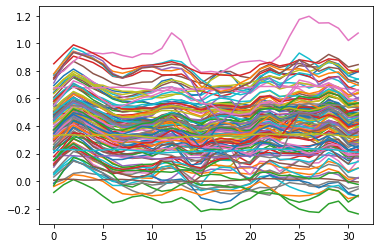

In [36]:
y = next(gen)[0][0]
np.save('input_trans.npy', y)   
plt.plot(y)
plt.show()

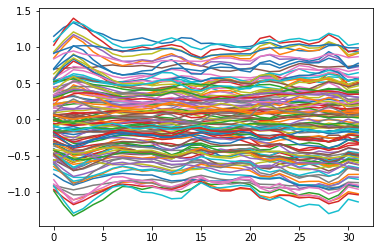

In [37]:
atten = MultiHeadAttention(120,10)
a,b = atten(y,y,y,True)
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

c = 0
for _ in a.numpy().T:
    plt.plot(list(_[0]))
    c+=1
plt.show()

np.save('attention_trans.npy', a.numpy())    

In [38]:
encoder_layer = EncoderLayer(120,10,120)

In [39]:
final_output.reshape(32,120)

<tf.Tensor: shape=(32, 120), dtype=float32, numpy=
array([[-0.5107466 , -0.93256956,  0.6935948 , ...,  0.85735023,
         1.6026328 , -0.01396036],
       [ 0.6469777 , -0.76918566,  1.862127  , ...,  0.6078357 ,
         1.4526455 , -1.0393839 ],
       [ 0.49848735, -0.6605401 ,  0.6649819 , ...,  0.50124705,
         1.4256682 , -0.57694656],
       ...,
       [ 1.1975207 ,  0.23018992,  1.0113423 , ..., -0.6193795 ,
         0.8700553 ,  0.21588677],
       [ 1.1513833 , -1.1231772 ,  0.7902087 , ..., -0.8424078 ,
        -0.28205746,  0.21066487],
       [ 0.6512687 , -1.3910339 ,  0.6858157 , ..., -0.6939865 ,
         1.2156951 ,  0.02646029]], dtype=float32)>

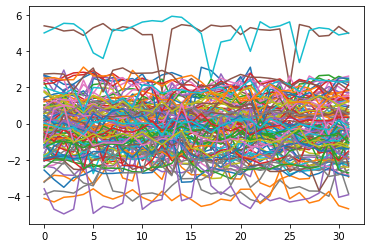

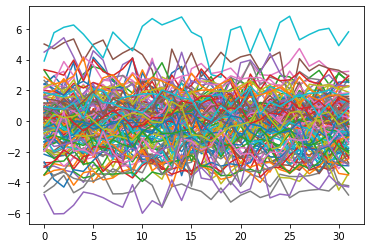

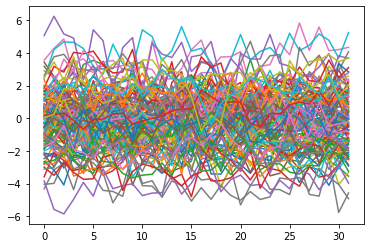

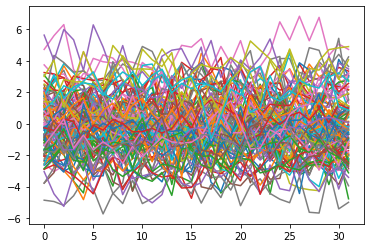

In [40]:

inp = encoder_layer.layernorm1(y)
ml_atn,b = atten(inp,inp,inp,True)
ml_atn = encoder_layer.dropout1(ml_atn,True)
added = layers.Add()([ml_atn,inp])
for_ffn = encoder_layer.layernorm2(added)
fo = encoder_layer.ffn(for_ffn)
fo = encoder_layer.dropout2(fo,True)
final_output = layers.Add()([fo,added])

for _ in final_output.numpy().T:
    plt.plot(list(_[0]))

plt.show()

for i in range(3):
    y = final_output.reshape(32,120)
    inp = encoder_layer.layernorm1(y)
    ml_atn,b = atten(inp,inp,inp,True)
    ml_atn = encoder_layer.dropout1(ml_atn,True)
    added = layers.Add()([ml_atn,inp])
    for_ffn = encoder_layer.layernorm2(added)
    fo = encoder_layer.ffn(for_ffn)
    fo = encoder_layer.dropout2(fo,True)
    final_output = layers.Add()([fo,added])
    
    for _ in final_output.numpy().T:
        plt.plot(list(_[0]))

    plt.show()




In [29]:
np.save('encd_trans.npy', final_output.numpy())    

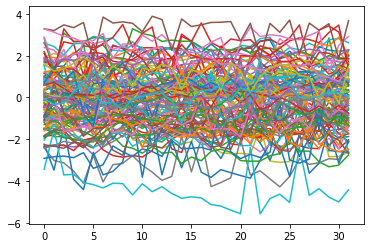

In [30]:
final_output
c = 0
for _ in final_output.numpy().T:
    plt.plot(list(_[0]))
    c+=1
plt.show()

np.save('encd_trans.npy', final_output.numpy())    

In [158]:
chs = []
for i in range(1,120):
    if 120%i==0:
        chs.append(i)

In [159]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen
        self.embed_dim = embed_dim

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = tf.reshape(x, [-1, self.maxlen, self.embed_dim])
        out = x + positions
        return out

In [160]:
st1 = sum(1 for _ in test_data_generator())

In [161]:
st2 = sum(1 for _ in train_data_generator())/50

In [162]:
st2

1092.6

In [173]:
projection_dim = 60
n_transformer_layers = 2
num_heads = 10

Mask = None
Dropout_train = True
drop_rate = 0.4


inputs = layers.Input(shape=input_shape)

embedding_layer = TokenAndPositionEmbedding(input_shape[0],projection_dim)



for i in range(n_transformer_layers):
    
  ml_layer = MultiHeadAttention(projection_dim, num_heads)
  encoder_layer = EncoderLayer(projection_dim, num_heads, projection_dim,drop_rate)

  if i==0:

    x = embedding_layer(inputs)
    x = encoder_layer.layernorm1(x)
    
  else:
    x = encoder_layer.layernorm1(encd)

  ml_atn = ml_layer(x,x,x,Mask)[0]
  ml_atn = encoder_layer.dropout1(ml_atn,True)
  added = layers.Add()([ml_atn,x])
  for_ffn = encoder_layer.layernorm2(added)
  fo = encoder_layer.ffn(for_ffn)
  fo = encoder_layer.dropout2(fo,True)
  encd = layers.Add()([fo,added])
encd = layers.GlobalMaxPooling1D()(encd)


#flt = layers.Flatten()(encd)


logits = layers.Dense(num_classes,activation='softmax')(encd)

model = keras.Model(inputs=inputs, outputs=logits)


In [164]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 120)]    0                                            
__________________________________________________________________________________________________
token_and_position_embedding_1  (None, 32, 60)       1920        input_3[0][0]                    
__________________________________________________________________________________________________
layer_normalization_20 (LayerNo (None, 32, 60)       60          token_and_position_embedding_1[0]
__________________________________________________________________________________________________
multi_head_attention_9 (MultiHe ((None, None, 60), ( 14640       layer_normalization_20[0][0]     
                                                                 layer_normalization_20[0][0

In [165]:
learning_rate = 0.0001
batch = 50
n_epoch = 300

opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, 
              loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])


In [166]:
hist = model.fit(train_dataset,validation_data=test_dataset,batch_size=batch,epochs=n_epoch)#callbacks=[checkpointer],shuffle=True)


2022-05-05 10:45:53.515064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
    275/Unknown - 4s 9ms/step - loss: 0.3728 - accuracy: 0.9418

KeyboardInterrupt: 

In [ ]:
import pandas as pd

In [ ]:
metrics = pd.read_csv('./log.csv')

In [ ]:
for x,y in zip(metrics.index[::-1],metrics['epoch'][::-1]):
    if y==0:
        break


In [ ]:
metrics = metrics.iloc[x:]

In [50]:
metrics

,epoch,accuracy,loss,val_accuracy,val_loss
1140,0,0.950283,0.211367,0.393827,3.222320
1141,1,0.986672,0.050392,0.505350,2.500426
1142,2,0.995496,0.015040,0.583749,2.380812
1143,3,0.998303,0.006187,0.657458,2.566102
1144,4,0.999367,0.002257,0.687726,2.503704
1145,5,0.999752,0.000941,0.709511,2.679421
1146,6,0.999890,0.000410,0.721277,2.949659


In [51]:
metrics.reset_index(inplace=True)

In [52]:
metrics.drop('index',axis=1,inplace=True)

In [53]:
metrics

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.950283,0.211367,0.393827,3.222320
1,1,0.986672,0.050392,0.505350,2.500426
2,2,0.995496,0.015040,0.583749,2.380812
3,3,0.998303,0.006187,0.657458,2.566102
4,4,0.999367,0.002257,0.687726,2.503704
5,5,0.999752,0.000941,0.709511,2.679421
6,6,0.999890,0.000410,0.721277,2.949659


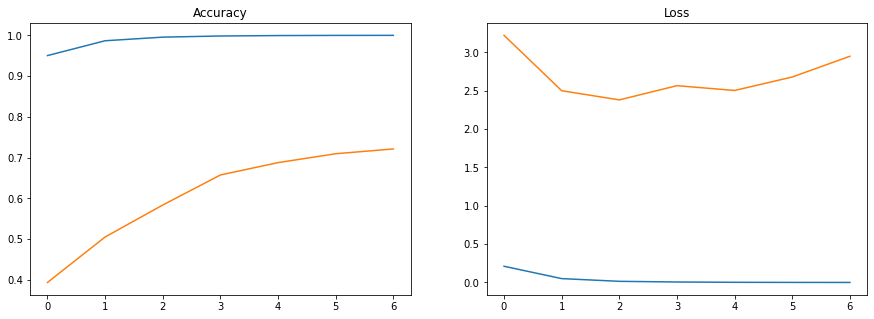

In [54]:
metrics

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].title.set_text("Accuracy")
ax[0].plot(metrics['accuracy'])
ax[0].plot(metrics['val_accuracy'])

ax[1].title.set_text("Loss")
ax[1].plot(metrics['loss'])
ax[1].plot(metrics['val_loss'])

#fig.savefig('./results_second_last.png')
plt.show()
